
Basic Info of Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248594 entries, 0 to 248593
Data columns (total 11 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Drug                           248594 non-null  object 
 1   Classified                     248300 non-null  float64
 2   MolWt                          248594 non-null  float64
 3   TPSA                           248594 non-null  float64
 4   NumHDonors                     248594 non-null  float64
 5   NumHAcceptors                  248594 non-null  float64
 6   MolLogP                        248594 non-null  float64
 7   Heavy_Atom_Count               248594 non-null  float64
 8   NumRotatableBonds              248594 non-null  float64
 9   Predicted_Toxicity_Percentage  248594 non-null  float64
 10  Toxicity class                 248594 non-null  object 
dtypes: float64(9), object(2)
memory usage: 20.9+ MB

First 5 Rows:
    

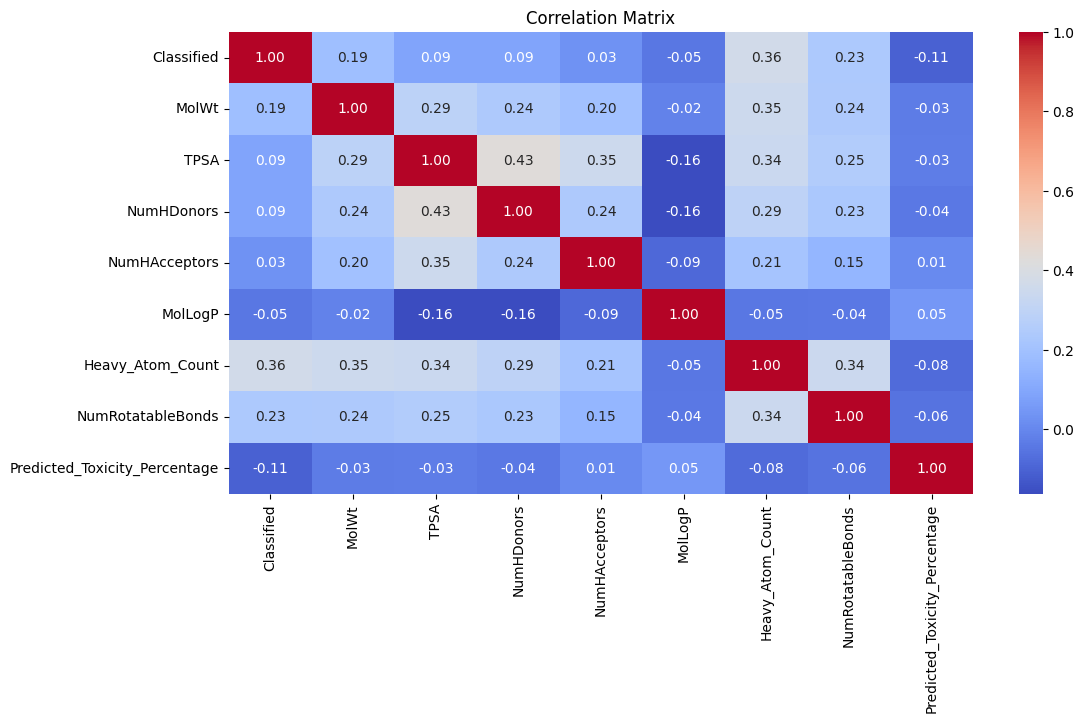

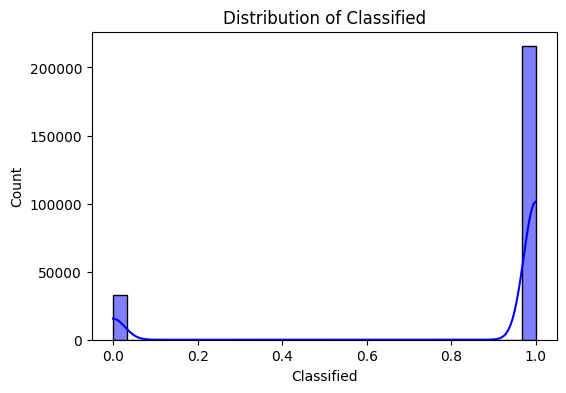

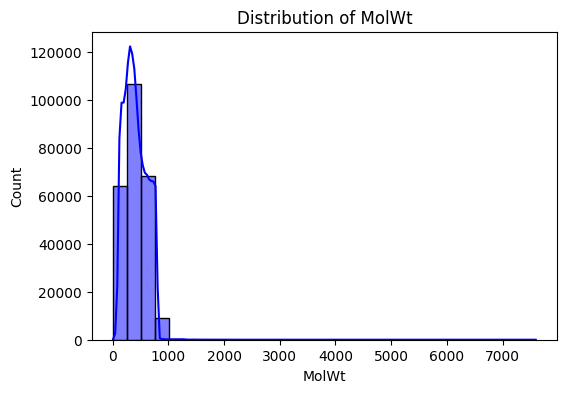

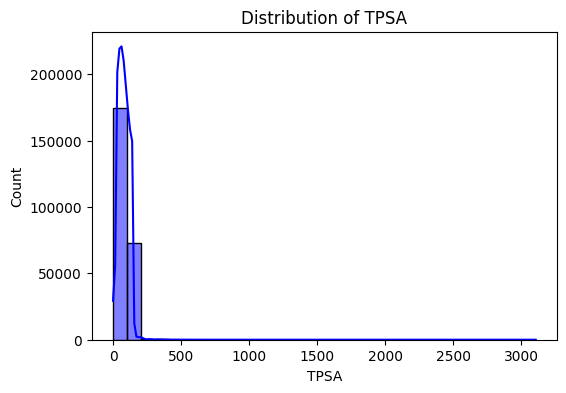

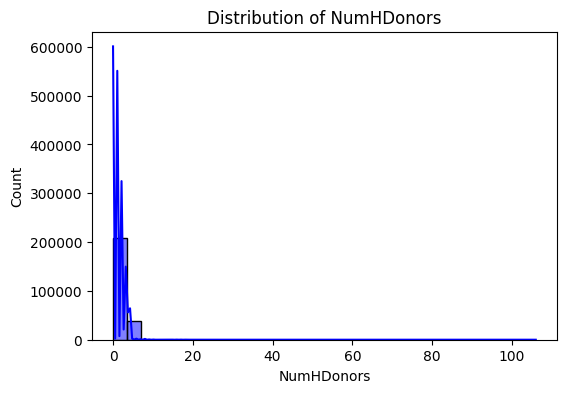

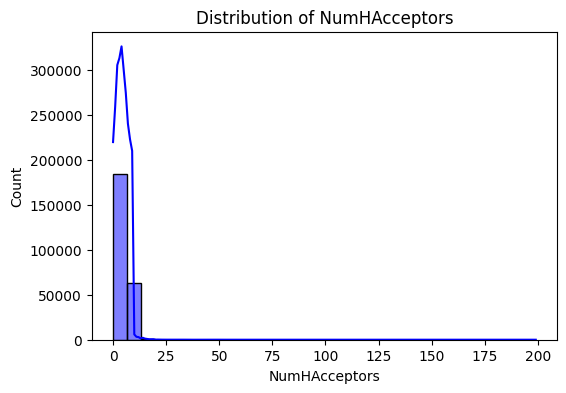

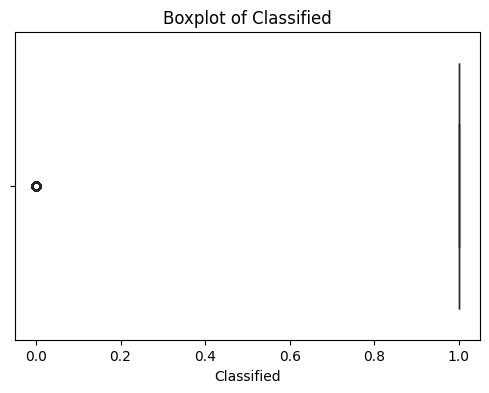

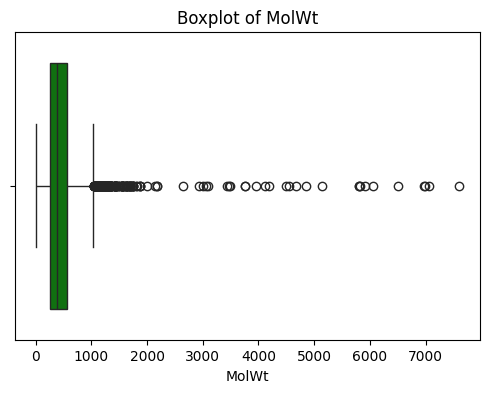

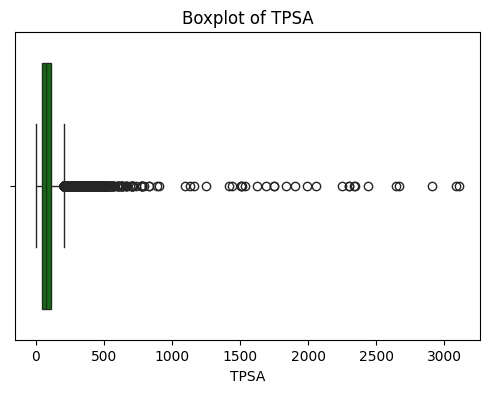

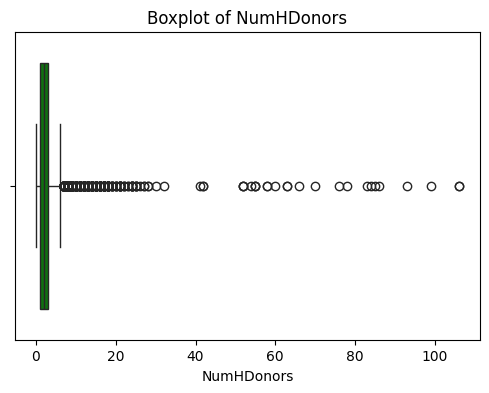

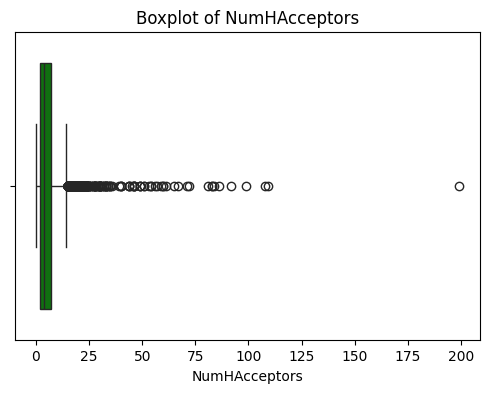

In [1]:
#EDA ANALYSIS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Load the dataset (replace 'your_file.csv' with the actual file path)
df = pd.read_csv('mp_dataf12.csv')


# Display basic information
print("\nBasic Info of Dataset:")
df.info()

# Display first few rows
print("\nFirst 5 Rows:")
print(df.head())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check for duplicate values
print("\nDuplicate Rows Count:", df.duplicated().sum())

# Summary statistics of numerical features
print("\nStatistical Summary:")
print(df.describe())

# Count unique values in categorical columns
print("\nUnique Values in Categorical Columns:")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")


# Convert numeric columns to proper data types
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
# Exclude 'Drug' and 'Toxicity class' from numeric analysis without dropping
num_df = df.select_dtypes(include=['number']).loc[:, ~df.select_dtypes(include=['number']).columns.isin(['Drug', 'Toxicity class'])]


if not num_df.empty:
    plt.figure(figsize=(12, 6))
    sns.heatmap(num_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Matrix")
    plt.show()
else:
    print("\nNo numeric columns available for correlation matrix.")


# Distribution of numerical columns
for col in num_df.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], bins=30, kde=True, color='blue')
    plt.title(f"Distribution of {col}")
    plt.show()

# Boxplots to detect outliers
for col in num_df.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col], color='green')
    plt.title(f"Boxplot of {col}")
    plt.show()

# # # Countplot for categorical features

for col in ['Classified']:
    if col in categorical_cols:
        plt.figure(figsize=(8, 4))
        if df[col].dtype == 'object':
            sns.countplot(y=df[col].astype(str), order=df[col].value_counts().index, palette='Set2')
        else:
            sns.countplot(y=df[col], order=df[col].value_counts().index, palette='Set2')
        plt.title(f"Count of {col}")
        plt.show()







In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv('/Users/uday/Downloads/mp_dataf12.csv')

# Strip spaces and convert to string
df['Toxicity class'] = df['Toxicity class'].astype(str).str.strip()

# Remove unwanted values
invalid_values = ["nan", "ChiralCenterCountAllPossible"]
df = df[~df['Toxicity class'].isin(invalid_values)]

# Check class distribution
if df['Toxicity class'].notna().sum() > 0:
    toxicity_counts = df['Toxicity class'].value_counts()
    
    print("\nCounts for each unique value in 'Toxicity class':")
    print(toxicity_counts)
    
    # Plot the class distribution
    plt.figure(figsize=(10, 5))
    sns.barplot(x=toxicity_counts.index, y=toxicity_counts.values, palette='viridis')
    plt.xticks(rotation=45, ha='right')
    plt.title("Toxicity Class Distribution")
    plt.xlabel("Toxicity Class")
    plt.ylabel("Count")
    plt.show()
else:
    print("\nNo valid data in 'Toxicity class' column after cleaning.")



Counts for each unique value in 'Toxicity class':
Toxicity class
Cardiotoxicity           30000
Reproductive toxicity    29071
Zinc toxicity            22385
Genotoxicity             22278
Mutagenecity             17017
Hepatotoxicity           16932
Eye irritation           16900
Eye corrosion            16334
Liver toxicity           15909
Carcinogenicity          15552
Acute Toxicity           15537
Skin toxicity            15404
Respiratory toxicity     15275
Name: count, dtype: int64


In [ ]:
#TRAINED TOXICITY PERCENATGE PREEDICTION MODEL USING GNN

import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader, InMemoryDataset
from torch_geometric.nn import GATConv, global_mean_pool
from rdkit import Chem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
import pickle

# Convert SMILES to Graph
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    atom_features = [
        [atom.GetAtomicNum(), atom.GetDegree(), atom.GetImplicitValence(),
         atom.GetFormalCharge(), int(atom.GetIsAromatic()), int(atom.IsInRing())]
        for atom in mol.GetAtoms()
    ]
    
    edge_index, edge_attr = [], []
    for bond in mol.GetBonds():
        indices = [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
        edge_index.extend([indices, indices[::-1]])
        attr = [bond.GetBondTypeAsDouble(), int(bond.GetIsAromatic()), int(bond.IsInRing())]
        edge_attr.extend([attr, attr])
    
    return Data(
        x=torch.tensor(atom_features, dtype=torch.float),
        edge_index=torch.tensor(edge_index, dtype=torch.long).t().contiguous(),
        edge_attr=torch.tensor(edge_attr, dtype=torch.float)
    )

# Load Dataset
df = pd.read_csv("/Users/uday/Downloads/merge file.csv").dropna()
df["Predicted_Toxicity_Percentage"] = pd.to_numeric(df["Predicted_Toxicity_Percentage"], errors="coerce")
df.dropna(subset=["Predicted_Toxicity_Percentage"], inplace=True)

scaler = MinMaxScaler()
df["Predicted_Toxicity_Percentage"] = scaler.fit_transform(df[["Predicted_Toxicity_Percentage"]])

with open("scaler1.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Custom Dataset Class
class ToxDataset(InMemoryDataset):
    def __init__(self, dataframe, transform=None, pre_transform=None):
        super().__init__(None, transform, pre_transform)
        self.data_list = [
            graph for _, row in dataframe.iterrows()
            if (graph := smiles_to_graph(row["Drug"])) is not None and setattr(graph, 'y', torch.tensor([row["Predicted_Toxicity_Percentage"]], dtype=torch.float)) is None
        ]
        self.data, self.slices = self.collate(self.data_list)
    
    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

# Train-Test Split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_loader = DataLoader(ToxDataset(train_df), batch_size=32, shuffle=True)
test_loader = DataLoader(ToxDataset(test_df), batch_size=32, shuffle=False)

# Define GNN Model
class GNNModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(6, 64, heads=4, concat=False)
        self.conv2 = GATConv(64, 128, heads=4, concat=False)
        self.conv3 = GATConv(128, 256, heads=4, concat=False)
        self.batch_norm = torch.nn.BatchNorm1d(256)
        self.dropout = torch.nn.Dropout(0.3)
        self.fc1 = torch.nn.Linear(256, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 1)
    
    def forward(self, data):
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = F.relu(self.conv2(x, data.edge_index))
        x = F.relu(self.conv3(x, data.edge_index))
        x = self.batch_norm(x)
        x = global_mean_pool(x, data.batch)
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNNModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)
criterion = torch.nn.MSELoss()

def train():
    model.train()
    total_loss, y_true, y_pred = 0, [], []
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        y_true.extend(data.y.view(-1).cpu().numpy())
        y_pred.extend(out.view(-1).cpu().detach().numpy())
    scheduler.step()
    return total_loss / len(train_loader), mean_absolute_error(y_true, y_pred), r2_score(y_true, y_pred)

def test():
    model.eval()
    total_loss, y_true, y_pred = 0, [], []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            loss = criterion(out, data.y.view(-1, 1))
            total_loss += loss.item()
            y_true.extend(data.y.view(-1).cpu().numpy())
            y_pred.extend(out.view(-1).cpu().numpy())
    return total_loss / len(test_loader), mean_absolute_error(y_true, y_pred), r2_score(y_true, y_pred)

# Training Loop
for epoch in range(50):
    train_loss, train_mae, train_r2 = train()
    test_loss, test_mae, test_r2 = test()
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train MAE = {train_mae:.4f}, Train R² = {train_r2:.4f}, "
          f"Test Loss = {test_loss:.4f}, Test MAE = {test_mae:.4f}, Test R² = {test_r2:.4f}")

torch.save(model.state_dict(), "gnn_toxicity_model_percent_final.pth")

# Prediction Function
def predict_toxicity(smiles):
    model.eval()
    graph = smiles_to_graph(smiles)
    if graph is None:
        return "Invalid SMILES string."
    graph = graph.to(device)
    with torch.no_grad():
        prediction = model(graph).item()
    return scaler.inverse_transform([[prediction]])[0][0]

model.load_state_dict(torch.load("gnn_toxicity_model_percent_final.pth", map_location=device))
print(f"Predicted Toxicity: {predict_toxicity('CCO'):.4f}")

Epoch 1: Train Loss = 0.0080, Train MAE = 0.0662, Train R² = 0.1380, Test Loss = 0.0078, Test MAE = 0.0675, Test R² = 0.1566
Epoch 2: Train Loss = 0.0072, Train MAE = 0.0629, Train R² = 0.2218, Test Loss = 0.0068, Test MAE = 0.0607, Test R² = 0.2580
Epoch 3: Train Loss = 0.0068, Train MAE = 0.0613, Train R² = 0.2608, Test Loss = 0.0066, Test MAE = 0.0608, Test R² = 0.2859
Epoch 4: Train Loss = 0.0065, Train MAE = 0.0599, Train R² = 0.2927, Test Loss = 0.0064, Test MAE = 0.0601, Test R² = 0.3018
Epoch 5: Train Loss = 0.0063, Train MAE = 0.0589, Train R² = 0.3131, Test Loss = 0.0061, Test MAE = 0.0569, Test R² = 0.3402
Epoch 6: Train Loss = 0.0062, Train MAE = 0.0580, Train R² = 0.3338, Test Loss = 0.0062, Test MAE = 0.0594, Test R² = 0.3324
Epoch 7: Train Loss = 0.0060, Train MAE = 0.0572, Train R² = 0.3517, Test Loss = 0.0057, Test MAE = 0.0553, Test R² = 0.3805
Epoch 8: Train Loss = 0.0059, Train MAE = 0.0566, Train R² = 0.3648, Test Loss = 0.0056, Test MAE = 0.0553, Test R² = 0.3890
Epoch 9: Train Loss = 0.0058, Train MAE = 0.0559, Train R² = 0.3768, Test Loss = 0.0056, Test MAE = 0.0557, Test R² = 0.3886
Epoch 10: Train Loss = 0.0057, Train MAE = 0.0556, Train R² = 0.3842, Test Loss = 0.0057, Test MAE = 0.0556, Test R² = 0.3843
Epoch 11: Train Loss = 0.0056, Train MAE = 0.0553, Train R² = 0.3895, Test Loss = 0.0056, Test MAE = 0.0559, Test R² = 0.3885
Epoch 12: Train Loss = 0.0056, Train MAE = 0.0550, Train R² = 0.3968, Test Loss = 0.0054, Test MAE = 0.0539, Test R² = 0.4147
Epoch 13: Train Loss = 0.0055, Train MAE = 0.0547, Train R² = 0.4032, Test Loss = 0.0055, Test MAE = 0.0541, Test R² = 0.4077
Epoch 14: Train Loss = 0.0055, Train MAE = 0.0544, Train R² = 0.4088, Test Loss = 0.0054, Test MAE = 0.0537, Test R² = 0.4172
Epoch 15: Train Loss = 0.0054, Train MAE = 0.0542, Train R² = 0.4132, Test Loss = 0.0055, Test MAE = 0.0542, Test R² = 0.4080
Epoch 16: Train Loss = 0.0054, Train MAE = 0.0540, Train R² = 0.4168, Test Loss = 0.0052, Test MAE = 0.0532, Test R² = 0.4325
Epoch 17: Train Loss = 0.0053, Train MAE = 0.0537, Train R² = 0.4210, Test Loss = 0.0052, Test MAE = 0.0536, Test R² = 0.4333
Epoch 18: Train Loss = 0.0053, Train MAE = 0.0536, Train R² = 0.4247, Test Loss = 0.0053, Test MAE = 0.0539, Test R² = 0.4232
Epoch 19: Train Loss = 0.0053, Train MAE = 0.0534, Train R² = 0.4276, Test Loss = 0.0052, Test MAE = 0.0528, Test R² = 0.4392
Epoch 20: Train Loss = 0.0052, Train MAE = 0.0532, Train R² = 0.4315, Test Loss = 0.0052, Test MAE = 0.0535, Test R² = 0.4309
Epoch 21: Train Loss = 0.0052, Train MAE = 0.0530, Train R² = 0.4352, Test Loss = 0.0053, Test MAE = 0.0537, Test R² = 0.4201
Epoch 22: Train Loss = 0.0052, Train MAE = 0.0529, Train R² = 0.4378, Test Loss = 0.0052, Test MAE = 0.0530, Test R² = 0.4339
Epoch 23: Train Loss = 0.0052, Train MAE = 0.0528, Train R² = 0.4405, Test Loss = 0.0051, Test MAE = 0.0522, Test R² = 0.4470
Epoch 24: Train Loss = 0.0051, Train MAE = 0.0526, Train R² = 0.4428, Test Loss = 0.0051, Test MAE = 0.0521, Test R² = 0.4444
Epoch 25: Train Loss = 0.0051, Train MAE = 0.0525, Train R² = 0.4448, Test Loss = 0.0053, Test MAE = 0.0545, Test R² = 0.4267
Epoch 26: Train Loss = 0.0051, Train MAE = 0.0525, Train R² = 0.4431, Test Loss = 0.0050, Test MAE = 0.0519, Test R² = 0.4540
Epoch 27: Train Loss = 0.0051, Train MAE = 0.0522, Train R² = 0.4501, Test Loss = 0.0051, Test MAE = 0.0520, Test R² = 0.4456
Epoch 28: Train Loss = 0.0051, Train MAE = 0.0521, Train R² = 0.4514, Test Loss = 0.0052, Test MAE = 0.0537, Test R² = 0.4386
Epoch 29: Train Loss = 0.0051, Train MAE = 0.0521, Train R² = 0.4528, Test Loss = 0.0050, Test MAE = 0.0523, Test R² = 0.4576
Epoch 30: Train Loss = 0.0050, Train MAE = 0.0520, Train R² = 0.4542, Test Loss = 0.0053, Test MAE = 0.0531, Test R² = 0.4255
Epoch 31: Train Loss = 0.0050, Train MAE = 0.0518, Train R² = 0.4570, Test Loss = 0.0053, Test MAE = 0.0540, Test R² = 0.4301
Epoch 32: Train Loss = 0.0050, Train MAE = 0.0518, Train R² = 0.4577, Test Loss = 0.0050, Test MAE = 0.0520, Test R² = 0.4630
Epoch 33: Train Loss = 0.0050, Train MAE = 0.0517, Train R² = 0.4588, Test Loss = 0.0050, Test MAE = 0.0518, Test R² = 0.4623
Epoch 34: Train Loss = 0.0050, Train MAE = 0.0516, Train R² = 0.4616, Test Loss = 0.0049, Test MAE = 0.0510, Test R² = 0.4729
Epoch 35: Train Loss = 0.0050, Train MAE = 0.0516, Train R² = 0.4613, Test Loss = 0.0049, Test MAE = 0.0512, Test R² = 0.4686
Epoch 36: Train Loss = 0.0049, Train MAE = 0.0515, Train R² = 0.4644, Test Loss = 0.0048, Test MAE = 0.0506, Test R² = 0.4794
Epoch 37: Train Loss = 0.0049, Train MAE = 0.0514, Train R² = 0.4646, Test Loss = 0.0050, Test MAE = 0.0513, Test R² = 0.4576
Epoch 38: Train Loss = 0.0049, Train MAE = 0.0514, Train R² = 0.4661, Test Loss = 0.0050, Test MAE = 0.0515, Test R² = 0.4602
Epoch 39: Train Loss = 0.0049, Train MAE = 0.0513, Train R² = 0.4673, Test Loss = 0.0049, Test MAE = 0.0510, Test R² = 0.4697
Epoch 40: Train Loss = 0.0049, Train MAE = 0.0513, Train R² = 0.4688, Test Loss = 0.0050, Test MAE = 0.0516, Test R² = 0.4594
Epoch 41: Train Loss = 0.0049, Train MAE = 0.0512, Train R² = 0.4699, Test Loss = 0.0050, Test MAE = 0.0521, Test R² = 0.4621
Epoch 42: Train Loss = 0.0049, Train MAE = 0.0511, Train R² = 0.4715, Test Loss = 0.0051, Test MAE = 0.0531, Test R² = 0.4442
Epoch 43: Train Loss = 0.0049, Train MAE = 0.0510, Train R² = 0.4728, Test Loss = 0.0048, Test MAE = 0.0509, Test R² = 0.4742
Epoch 44: Train Loss = 0.0049, Train MAE = 0.0511, Train R² = 0.4714, Test Loss = 0.0049, Test MAE = 0.0507, Test R² = 0.4706
Epoch 45: Train Loss = 0.0048, Train MAE = 0.0509, Train R² = 0.4754, Test Loss = 0.0050, Test MAE = 0.0513, Test R² = 0.4609
Epoch 46: Train Loss = 0.0048, Train MAE = 0.0509, Train R² = 0.4752, Test Loss = 0.0049, Test MAE = 0.0504, Test R² = 0.4726
Epoch 47: Train Loss = 0.0048, Train MAE = 0.0509, Train R² = 0.4751, Test Loss = 0.0048, Test MAE = 0.0508, Test R² = 0.4794
Epoch 48: Train Loss = 0.0048, Train MAE = 0.0508, Train R² = 0.4770, Test Loss = 0.0048, Test MAE = 0.0511, Test R² = 0.4762
Epoch 49: Train Loss = 0.0048, Train MAE = 0.0507, Train R² = 0.4784, Test Loss = 0.0049, Test MAE = 0.0506, Test R² = 0.4707
Epoch 50: Train Loss = 0.0048, Train MAE = 0.0507, Train R² = 0.4788, Test Loss = 0.0048, Test MAE = 0.0506, Test R² = 0.4820

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create subplots (2 columns, 3 rows)
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Plot Train Loss
axs[0, 0].plot(epochs, train_loss, marker="o", linestyle="-", color="blue")
axs[0, 0].set_title("Train Loss")
axs[0, 0].set_xlabel("Epochs")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].grid(True)

# Plot Test Loss
axs[0, 1].plot(epochs, test_loss, marker="s", linestyle="--", color="red")
axs[0, 1].set_title("Test Loss")
axs[0, 1].set_xlabel("Epochs")
axs[0, 1].set_ylabel("Loss")
axs[0, 1].grid(True)

# Plot Train MAE
axs[1, 0].plot(epochs, train_mae, marker="o", linestyle="-", color="blue")
axs[1, 0].set_title("Train MAE")
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("MAE")
axs[1, 0].grid(True)

# Plot Test MAE
axs[1, 1].plot(epochs, test_mae, marker="s", linestyle="--", color="red")
axs[1, 1].set_title("Test MAE")
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("MAE")
axs[1, 1].grid(True)

# Plot Train R²
axs[2, 0].plot(epochs, train_r2, marker="o", linestyle="-", color="blue")
axs[2, 0].set_title("Train R² Score")
axs[2, 0].set_xlabel("Epochs")
axs[2, 0].set_ylabel("R² Score")
axs[2, 0].grid(True)

# Plot Test R²
axs[2, 1].plot(epochs, test_r2, marker="s", linestyle="--", color="red")
axs[2, 1].set_title("Test R² Score")
axs[2, 1].set_xlabel("Epochs")
axs[2, 1].set_ylabel("R² Score")
axs[2, 1].grid(True)

# Adjust layout and show plots
plt.tight_layout()
plt.show()

In [ ]:
#USING TRAINED MODEL OF TOXICITY PERCENATGE PREDICTION

import torch
from rdkit import Chem
from torch_geometric.data import Data

# Define the same model architecture used during training
class GNNModel(torch.nn.Module):
    def __init__(self):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(4, 64)
        self.conv2 = GCNConv(64, 128)
        self.fc1 = torch.nn.Linear(128, 64)
        self.fc2 = torch.nn.Linear(64, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, data.batch)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Predict toxicity percentage
        return x

# Function to convert SMILES to Graph
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    atom_features = []
    edge_index = []
    edge_attr = []

    # Node features (atoms)
    for atom in mol.GetAtoms():
        atom_features.append([
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetImplicitValence(),
            atom.GetFormalCharge()
        ])

    # Edge features (bonds)
    for bond in mol.GetBonds():
        edge_index.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
        edge_index.append([bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()])
        edge_attr.append([bond.GetBondTypeAsDouble()])
        edge_attr.append([bond.GetBondTypeAsDouble()])

    # Convert to tensors
    x = torch.tensor(atom_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNNModel().to(device)
model.load_state_dict(torch.load("gnn_toxicity_model_percent_final.pth", map_location=device))
model.eval()

# Function to predict toxicity for a new SMILES string
def predict_toxicity(smiles):
    graph = smiles_to_graph(smiles)
    if graph is None:
        print("Invalid SMILES string.")
        return None

    graph = graph.to(device)
    with torch.no_grad():
        prediction = model(graph).item()

    return prediction

# Example usage
sample_smiles = "O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2ccccc2C)C)CC1(C)C"  # Replace with actual SMILES string
predicted_toxicity = predict_toxicity(sample_smiles)
predicted_toxicity*=100
print(f"Predicted Toxicity: {predicted_toxicity:.4f}")


Predicted Toxicity: 43.2942


In [ ]:
#TRAINED MODEL OF TOXICITY CLASS RPREDICTION USING GNN

import os
import warnings
import logging
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pickle
import os
import warnings
import logging
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import pickle

# Disable all warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore")

# Disable logging
logging.disable(logging.CRITICAL)

# Block RDKit warnings
from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")
RDLogger.DisableLog("rdApp.error")
RDLogger.DisableLog("rdApp.warning")
RDLogger.DisableLog("rdApp.info")

# Prevent joblib from printing
os.environ["JOBLIB_LOG_LEVEL"] = "ERROR"

# Force-set environment variable for Python
os.environ["PYTHONWARNINGS"] = "ignore"

# Redirect stderr & stdout to null
class NullWriter:
    def write(self, msg): pass
    def flush(self): pass

# Load dataset
df = pd.read_csv('/Users/uday/Downloads/merge file.csv', low_memory=False)
df = df.dropna(subset=['Drug'])

# Convert SMILES to standard format
def fix_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        Chem.SanitizeMol(mol)
        return Chem.MolToSmiles(mol)
    except:
        return None

df['Fixed_SMILES'] = df['Drug'].apply(fix_smiles)
df = df.dropna(subset=['Fixed_SMILES'])

# Store class labels before encoding
class_labels = df['Toxicity class'].astype(str).unique()
label_encoder = LabelEncoder()
label_encoder.fit(class_labels)
df['Toxicity class'] = label_encoder.transform(df['Toxicity class'].astype(str))

with open('label_encoder_class.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)


# Convert numeric columns
descriptor_cols = ['MolWt', 'TPSA', 'NumHDonors', 'NumHAcceptors', 'MolLogP', 
                   'Heavy_Atom_Count', 'NumRotatableBonds', 'Predicted_Toxicity_Percentage',
                   'Toxicity class', 'Classified']
df[descriptor_cols] = df[descriptor_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# Normalize features
scaler = StandardScaler()
df[descriptor_cols] = scaler.fit_transform(df[descriptor_cols])



# Define an improved GNN model with added layers and regularization
class EnhancedHybridGNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(EnhancedHybridGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, 64)
        self.conv2 = GCNConv(64, 128)
        self.conv3 = GCNConv(128, 256)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)  # Dropout for regularization

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        
        # Using max pooling instead of mean pooling for better feature representation
        x = global_max_pool(x, data.batch)  
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout before final layer
        return self.fc2(x)


# Prepare data
def smiles_to_graph(smiles, features):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    atoms = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    edges = [(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()) for bond in mol.GetBonds()]
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous() if edges else torch.empty((2,0), dtype=torch.long)
    x = torch.tensor(atoms, dtype=torch.float32).view(-1, 1)
    y = torch.tensor(np.array(features, dtype=np.float32))
    return Data(x=x, edge_index=edge_index, y=y, smiles=smiles)

graphs = [smiles_to_graph(row['Fixed_SMILES'], row[descriptor_cols].values) for _, row in df.iterrows()]
graphs = [g for g in graphs if g is not None]

# Train-test split
train_data, test_data = train_test_split(graphs, test_size=0.2, random_state=42, stratify=df['Toxicity class'])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Train model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(label_encoder.classes_)
model = EnhancedHybridGNN(1, num_classes).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
from sklearn.utils.class_weight import compute_class_weight

import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool


# Modify optimizer and learning rate scheduler

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

# Get class labels
class_counts = df['Toxicity class'].value_counts().sort_index().values
num_classes1 = len(class_counts)

from sklearn.utils.class_weight import compute_class_weight

# Get unique class labels from the dataset
unique_classes = np.unique(df['Toxicity class'])

# Compute class weights (inverse proportional to class frequency)
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=df['Toxicity class'])

# Convert to PyTorch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)


# Define loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

num_epochs = 50

train_losses, train_accuracies,  test_accuracies,   test_losses=[],[],[],[]
  

# New training loop with early stopping and LR scheduler
best_val_loss = float('inf')
patience = 10
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        output = model(batch)  
        target = batch.y.view(-1).long().to(device)  # Flatten the target labels

        # Ensure target and output match shapes
        if target.shape[0] != output.shape[0]:  
            target = target[:output.shape[0]]  # Adjust target size if necessary

        mask = (target >= 0) & (target < output.shape[1])  # Ensure target labels are within the valid range
        if mask.sum() == 0:  # Skip if no valid target
            continue  

        valid_target = target[mask]  # Filter valid targets
        valid_output = output[mask]  # Filter corresponding outputs

        loss = criterion(valid_output, valid_target)  # Weighted Loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (valid_output.argmax(dim=1) == valid_target).sum().item()  # Compute correct predictions
        total += valid_target.size(0)  # Total valid targets

    # Calculate training accuracy
    train_accuracy = 100 * correct / total if total > 0 else 0
    train_losses.append(total_loss / len(train_loader))  # Store average training loss
    train_accuracies.append(train_accuracy)  # Store training accuracy

    print(f"Epoch {epoch+1}: Train Loss={total_loss:.4f}, Train Accuracy={train_accuracy:.2f}%")

    # Test the model on the validation/test set
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            output = model(batch)
            target = batch.y.view(-1).long().to(device)
            
            if target.shape[0] != output.shape[0]:
                target = target[:output.shape[0]]

            mask = (target >= 0) & (target < output.shape[1])
            if mask.sum() == 0:
                continue

            valid_target = target[mask]
            valid_output = output[mask]

            loss = criterion(valid_output, valid_target)
            total_loss += loss.item()
            correct += (valid_output.argmax(dim=1) == valid_target).sum().item()
            total += valid_target.size(0)

    # Calculate test accuracy
    test_accuracy = 100 * correct / total if total > 0 else 0
    test_losses.append(total_loss / len(test_loader))  # Store average test loss
    test_accuracies.append(test_accuracy)  # Store test accuracy

    print(f"Test Loss={total_loss:.4f}, Test Accuracy={test_accuracy:.2f}%")

# Plot the metrics
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12, 5))

# Plot training and test loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')

# Plot training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Test Accuracy')

plt.tight_layout()
plt.show()


# Load the best model for final evaluation
model.load_state_dict(torch.load('/Users/uday/Downloads/gnn_model_toxiicty_class2.pth'))




# Save model
with open('/Users/uday/Downloads/gnn_model_toxiicty_class2.pth', 'wb') as f:
    pickle.dump(model, f)

from torch_geometric.data import Batch
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import numpy as np

def extract_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Invalid SMILES
    
    # Correct function for Morgan Fingerprint
    features = np.array(rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024))
    return features


def predict(smiles):
    features = extract_features(smiles)
    if features is None:
        return "Invalid SMILES"
    
    graph = smiles_to_graph(smiles, features)  # Pass extracted features
    
    if graph is None:
        return "Invalid SMILES"
    
    graph = graph.to(device)
    batched_graph = Batch.from_data_list([graph])
    
    output = model(batched_graph)  # Forward pass
    predicted_class = output.argmax(dim=1).item()
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    return predicted_label




# Example prediction
sample_smiles = df['Fixed_SMILES'].iloc[0]
predicted_class = predict(sample_smiles)
print(f"Predicted Toxicity Class for {sample_smiles}: {predicted_class}")



Epoch 1: Train Loss=3376.9198, Train Accuracy=87.59%
Test Loss=840.0230, Test Accuracy=87.64%
Epoch 2: Train Loss=3380.3496, Train Accuracy=87.60%
Test Loss=841.3419, Test Accuracy=87.64%
Epoch 3: Train Loss=3380.6582, Train Accuracy=87.65%
Test Loss=840.2829, Test Accuracy=87.64%
Epoch 4: Train Loss=3363.3007, Train Accuracy=87.74%
Test Loss=839.9824, Test Accuracy=87.64%
Epoch 5: Train Loss=3334.1494, Train Accuracy=87.90%
Test Loss=839.6160, Test Accuracy=87.64%
Epoch 6: Train Loss=3366.9555, Train Accuracy=87.59%
Test Loss=839.8529, Test Accuracy=87.64%
Epoch 7: Train Loss=3335.7371, Train Accuracy=87.78%
Test Loss=839.8849, Test Accuracy=87.64%
Epoch 8: Train Loss=3372.3723, Train Accuracy=87.65%
Test Loss=839.6715, Test Accuracy=87.64%
Epoch 9: Train Loss=3352.3999, Train Accuracy=87.67%
Test Loss=839.8334, Test Accuracy=87.64%
Epoch 10: Train Loss=3377.2936, Train Accuracy=87.59%
Test Loss=839.8599, Test Accuracy=87.64%
Epoch 11: Train Loss=3352.7910, Train Accuracy=87.68%
Test Loss=839.9518, Test Accuracy=87.64%
Epoch 12: Train Loss=3357.6045, Train Accuracy=87.69%
Test Loss=840.1809, Test Accuracy=87.64%
Epoch 13: Train Loss=3353.6078, Train Accuracy=87.71%
Test Loss=840.8302, Test Accuracy=87.64%
Epoch 14: Train Loss=3354.4417, Train Accuracy=87.68%
Test Loss=840.4376, Test Accuracy=87.64%
Epoch 15: Train Loss=3400.2702, Train Accuracy=87.47%
Test Loss=839.6428, Test Accuracy=87.64%
Epoch 16: Train Loss=3406.8529, Train Accuracy=87.48%
Test Loss=839.8355, Test Accuracy=87.64%
Epoch 17: Train Loss=3373.6672, Train Accuracy=87.61%
Test Loss=839.7725, Test Accuracy=87.64%
Epoch 18: Train Loss=3362.7707, Train Accuracy=87.67%
Test Loss=839.7641, Test Accuracy=87.64%
Epoch 19: Train Loss=3380.2519, Train Accuracy=87.56%
Test Loss=839.9579, Test Accuracy=87.64%
Epoch 20: Train Loss=3341.1264, Train Accuracy=87.75%
Test Loss=840.0614, Test Accuracy=87.64%
Epoch 21: Train Loss=3383.8707, Train Accuracy=87.54%
Test Loss=840.0931, Test Accuracy=87.64%
Epoch 22: Train Loss=3366.5350, Train Accuracy=87.61%
Test Loss=840.2396, Test Accuracy=87.64%
Epoch 23: Train Loss=3338.5784, Train Accuracy=87.74%
Test Loss=839.6945, Test Accuracy=87.64%
Epoch 24: Train Loss=3365.7238, Train Accuracy=87.61%
Test Loss=839.6353, Test Accuracy=87.64%
Epoch 25: Train Loss=3343.8475, Train Accuracy=87.75%
Test Loss=839.6249, Test Accuracy=87.64%
Epoch 26: Train Loss=3345.8858, Train Accuracy=87.72%
Test Loss=839.5813, Test Accuracy=87.64%
Epoch 27: Train Loss=3366.3145, Train Accuracy=87.65%
Test Loss=839.7037, Test Accuracy=87.64%
Epoch 28: Train Loss=3362.1579, Train Accuracy=87.69%
Test Loss=839.7306, Test Accuracy=87.64%
Epoch 29: Train Loss=3359.7920, Train Accuracy=87.67%
Test Loss=839.6500, Test Accuracy=87.64%
Epoch 30: Train Loss=3341.1611, Train Accuracy=87.70%
Test Loss=839.7056, Test Accuracy=87.64%
Epoch 31: Train Loss=3347.8179, Train Accuracy=87.74%
Test Loss=839.8189, Test Accuracy=87.64%
Epoch 32: Train Loss=3373.5653, Train Accuracy=87.64%
Test Loss=839.5533, Test Accuracy=87.64%
Epoch 33: Train Loss=3344.7858, Train Accuracy=87.72%
Test Loss=839.5445, Test Accuracy=87.64%
Epoch 34: Train Loss=3295.4689, Train Accuracy=87.99%
Test Loss=839.8785, Test Accuracy=87.64%
Epoch 35: Train Loss=3349.0421, Train Accuracy=87.68%
Test Loss=840.0391, Test Accuracy=87.64%
Epoch 36: Train Loss=3354.9809, Train Accuracy=87.70%
Test Loss=839.5815, Test Accuracy=87.64%
Epoch 37: Train Loss=3342.1997, Train Accuracy=87.73%
Test Loss=839.5872, Test Accuracy=87.64%
Epoch 38: Train Loss=3364.9694, Train Accuracy=87.66%
Test Loss=839.5752, Test Accuracy=87.64%
Epoch 39: Train Loss=3380.9968, Train Accuracy=87.55%
Test Loss=839.8468, Test Accuracy=87.64%
Epoch 40: Train Loss=3367.1650, Train Accuracy=87.63%
Test Loss=839.5880, Test Accuracy=87.64%
Epoch 41: Train Loss=3364.9434, Train Accuracy=87.66%
Test Loss=839.6811, Test Accuracy=87.64%
Epoch 42: Train Loss=3363.9558, Train Accuracy=87.68%
Test Loss=839.6072, Test Accuracy=87.64%
Epoch 43: Train Loss=3365.5425, Train Accuracy=87.66%
Test Loss=839.7013, Test Accuracy=87.64%
Epoch 44: Train Loss=3351.9143, Train Accuracy=87.69%
Test Loss=839.6221, Test Accuracy=87.64%
Epoch 45: Train Loss=3360.8577, Train Accuracy=87.66%
Test Loss=839.5599, Test Accuracy=87.64%
Epoch 46: Train Loss=3330.0707, Train Accuracy=87.81%
Test Loss=839.6988, Test Accuracy=87.64%
Epoch 47: Train Loss=3355.5136, Train Accuracy=87.70%
Test Loss=839.7206, Test Accuracy=87.64%
Epoch 48: Train Loss=3349.0421, Train Accuracy=87.68%
Test Loss=840.0391, Test Accuracy=87.64%
Epoch 49: Train Loss=3383.8707, Train Accuracy=87.82%
Test Loss=840.0931, Test Accuracy=87.64%
Epoch 50: Train Loss=3335.7371, Train Accuracy=87.71%
Test Loss=839.8849, Test Accuracy=87.64%

In [ ]:
plt.figure(figsize=(12, 10))
epochs = range(1, 48)
# Plot Train Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Test Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, test_losses, label='Test Loss', color='red', marker='o')
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Train Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue', marker='o')
plt.title('Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plot Test Accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='red', marker='o')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


In [48]:
#USING TRAINED MODEL OF TOXICITY CLASS PREDICTION

import torch
import torch.nn as nn
import pickle
from torch_geometric.data import Batch, Data
from torch_geometric.nn import GCNConv, global_mean_pool
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import numpy as np
from rdkit import RDLogger

# Disable RDKit warnings
RDLogger.DisableLog("rdApp.*")

# Load label encoder
with open('/Users/uday/Downloads/label_encoder_class.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# Define the HybridGNN model
class HybridGNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(HybridGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, 64)
        self.conv2 = GCNConv(64, 128)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, data.batch)  # Aggregate features
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Load trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(label_encoder.classes_)
model = HybridGNN(1, num_classes).to(device)
model.load_state_dict(torch.load('/Users/uday/Downloads/gnn_model_toxiicty_class2.pth', map_location=device))
model.eval()

# Extract molecular features
def extract_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Invalid SMILES
    return np.array(rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024))

# Convert SMILES to graph
def smiles_to_graph(smiles, features):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    atoms = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    edges = [(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()) for bond in mol.GetBonds()]
    
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous() if edges else torch.empty((2, 0), dtype=torch.long)
    x = torch.tensor(atoms, dtype=torch.float32).view(-1, 1)  # Convert atoms to tensor
    y = torch.tensor(features, dtype=torch.float32)  # Feature tensor

    return Data(x=x, edge_index=edge_index, y=y, smiles=smiles)

# Predict toxicity class
def predict(smiles):
    features = extract_features(smiles)
    if features is None:
        return "Invalid SMILES"
    
    graph = smiles_to_graph(smiles, features)
    if graph is None:
        return "Invalid SMILES"
    
    graph = graph.to(device)
    batched_graph = Batch.from_data_list([graph])
    
    with torch.no_grad():
        output = model(batched_graph)
    
    predicted_class = output.argmax(dim=1).item()
    return label_encoder.inverse_transform([predicted_class])[0]

# Example usage
sample_smiles = "CCO"  # Example SMILES
predicted_class = predict(sample_smiles)
print(f"Predicted Toxicity Class for {sample_smiles}: {predicted_class}")

Predicted Toxicity Class for CCO: Acute Toxicity


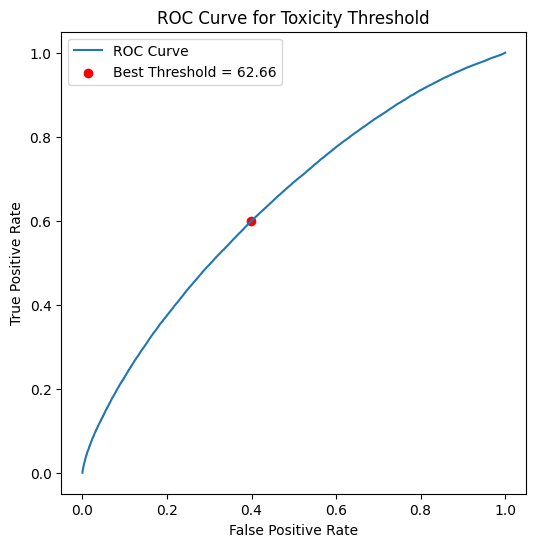

Learned Toxicity Threshold: 62.66


In [ ]:
#CALCULATED TOXICITY BINARY CLASSIFICATION THRESHOLD USING Youden's J statistic

import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve

#  Load dataset
df = pd.read_csv("/Users/uday/Downloads/merge file.csv")

#  Ensure 'Classified' and 'Predicted_Toxicity_Percentage' are numeric
df["Classified"] = pd.to_numeric(df["Classified"], errors="coerce")
df["Predicted_Toxicity_Percentage"] = pd.to_numeric(df["Predicted_Toxicity_Percentage"], errors="coerce")

#  Drop any remaining NaN values
df = df.dropna(subset=["Classified", "Predicted_Toxicity_Percentage"])

#  Convert to integer
df["Classified"] = df["Classified"].astype(int)

#  Extract values
toxicity_percentage = df["Predicted_Toxicity_Percentage"].values  # Toxicity % (Continuous)
toxic_label = df["Classified"].values  # Binary Toxic (0 or 1)

#  Compute ROC curve
fpr, tpr, thresholds = roc_curve(toxic_label, toxicity_percentage)


#  Find best threshold using Youden's J statistic (tpr - fpr)
best_idx = np.argmax(tpr - fpr)
best_threshold = thresholds[best_idx]

#  Plot ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f"Best Threshold = {best_threshold:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Toxicity Threshold")
plt.legend()
plt.show()

print(f"Learned Toxicity Threshold: {best_threshold:.2f}")


In [27]:
import torch
import torch.nn as nn
import pickle
from torch_geometric.data import Batch, Data
from torch_geometric.nn import GCNConv, global_mean_pool
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, Descriptors
import numpy as np
from rdkit import RDLogger

# Disable RDKit warnings
RDLogger.DisableLog("rdApp.*")

# Load label encoder
with open('/Users/uday/Downloads/label_encoder_class.pkl', 'rb') as f:
    label_encoder1 = pickle.load(f)

# Define the HybridGNN model
class HybridGNN1(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(HybridGNN1, self).__init__()
        self.conv1 = GCNConv(input_dim, 64)
        self.conv2 = GCNConv(64, 128)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, data.batch)  # Aggregate features
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Load trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes1 = len(label_encoder1.classes_)
model1 = HybridGNN1(1, num_classes1).to(device)
model1.load_state_dict(torch.load('/Users/uday/Downloads/gnn_model_toxiicty_class2.pth', map_location=device))
model1.eval()

# Extract molecular features
def extract_features1(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Invalid SMILES
    return np.array(rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024))

# Convert SMILES to graph
def smiles_to_graph1(smiles, features):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    atoms = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    edges = [(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()) for bond in mol.GetBonds()]
    
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous() if edges else torch.empty((2, 0), dtype=torch.long)
    x = torch.tensor(atoms, dtype=torch.float32).view(-1, 1)  # Convert atoms to tensor
    y = torch.tensor(features, dtype=torch.float32)  # Feature tensor

    return Data(x=x, edge_index=edge_index, y=y, smiles=smiles)

# Predict toxicity class
def predict_class1(smiles):
    features = extract_features1(smiles)
    if features is None:
        return "Invalid SMILES"
    
    graph = smiles_to_graph1(smiles, features)
    if graph is None:
        return "Invalid SMILES"
    
    graph = graph.to(device)
    batched_graph = Batch.from_data_list([graph])
    
    with torch.no_grad():
        output = model1(batched_graph)
    
    predicted_class1 = output.argmax(dim=1).item()
    return label_encoder1.inverse_transform([predicted_class1])[0]

# Define the GNN Model for Toxicity Percentage Prediction
class GNNModel2(torch.nn.Module):
    def __init__(self):
        super(GNNModel2, self).__init__()
        self.conv1 = GCNConv(4, 64)
        self.conv2 = GCNConv(64, 128)
        self.fc1 = torch.nn.Linear(128, 64)
        self.fc2 = torch.nn.Linear(64, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, data.batch)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Load the trained model for toxicity prediction
model2 = GNNModel2().to(device)
model2.load_state_dict(torch.load("/Users/uday/Downloads//gnn_toxicity_model_percent_final.pth", map_location=device))
model2.eval()

# Convert SMILES to Graph
def smiles_to_graph2(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    atom_features = []
    edge_index = []
    edge_attr = []

    for atom in mol.GetAtoms():
        atom_features.append([
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetImplicitValence(),
            atom.GetFormalCharge()
        ])

    for bond in mol.GetBonds():
        edge_index.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
        edge_index.append([bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()])
        edge_attr.append([bond.GetBondTypeAsDouble()])
        edge_attr.append([bond.GetBondTypeAsDouble()])

    x = torch.tensor(atom_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# Predict Toxicity Percentage
def predict_toxicity2(smiles):
    graph = smiles_to_graph2(smiles)
    if graph is None:
        return "Invalid SMILES"
    
    graph = graph.to(device)
    with torch.no_grad():
        prediction = model2(graph).item() * 100
    
    return prediction

# Function to calculate molecular descriptors
def calculate_descriptors2(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    return {
        "MolWt": Descriptors.MolWt(mol),
        "MolLogP": Descriptors.MolLogP(mol),
        "NumHDonors": Descriptors.NumHDonors(mol),
        "NumHAcceptors": Descriptors.NumHAcceptors(mol),
        "TPSA": Descriptors.TPSA(mol),
        "RingCount": Descriptors.RingCount(mol),
        "HeavyAtomCount": Descriptors.HeavyAtomCount(mol)
    }

# User input
smiles_input = input("Enter a SMILES string: ").strip()

predicted_class1 = predict_class1(smiles_input)
predicted_toxicity2 = predict_toxicity2(smiles_input)
descriptors2 = calculate_descriptors2(smiles_input)

if descriptors2:
    best_threshold = 62.66  # Example threshold
    toxicity_label2 = 1 if predicted_toxicity2 > best_threshold else 0
    
    print("\n=== Molecular Descriptor Values ===")
    for name, value in descriptors2.items():
        print(f"{name:<15}: {value:.4f}")
    
    print("\n=== Toxicity Prediction ===")
    print(f"Toxicity Percentage : {predicted_toxicity2:.4f}")
    print(f"Toxicity Class      : {predicted_class1}")
    print(f"Toxicity Label      : {toxicity_label2}")
else:
    print("Invalid SMILES string!")


=== Molecular Descriptor Values ===
MolWt          : 46.0690
MolLogP        : -0.0014
NumHDonors     : 1.0000
NumHAcceptors  : 1.0000
TPSA           : 20.2300
RingCount      : 0.0000
HeavyAtomCount : 3.0000

=== Toxicity Prediction ===
Toxicity Percentage : 19.0682
Toxicity Class      : Acute Toxicity
Toxicity Label      : 0
